In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pickle
import csv
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
import gdown
import joblib

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import lightgbm as lgb

import eli5
from eli5.sklearn import PermutationImportance

# 코드 셀 실행 후 경고를 무시
# import warnings
# warnings.filterwarnings(action='ignore')

### Load Table

In [2]:
# pickle에서 데이터프레임 다시 불러오기
with open('data.pickle', 'rb') as f:
    df = pickle.load(f)

In [3]:
df

,번지,본번,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,구,동,계약년,계약월,평균공시가격,계약일,date
0,658-1,658.0,개포6차우성,79.97,201712,3,1987,언주로 3,124000.0,0,강남구,개포동,2017,12,120960.000000,8,2017-12-08
1,658-1,658.0,개포6차우성,79.97,201712,4,1987,언주로 3,123500.0,0,강남구,개포동,2017,12,120960.000000,22,2017-12-22
2,658-1,658.0,개포6차우성,54.98,201712,5,1987,언주로 3,91500.0,0,강남구,개포동,2017,12,120960.000000,28,2017-12-28
3,658-1,658.0,개포6차우성,79.97,201801,4,1987,언주로 3,130000.0,0,강남구,개포동,2018,01,120960.000000,3,2018-01-03
4,658-1,658.0,개포6차우성,79.97,201801,2,1987,언주로 3,117000.0,0,강남구,개포동,2018,01,120960.000000,8,2018-01-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,816,816.0,신내우디안1단지,84.65,202307,13,2014,신내역로1길 85,NaN,1,중랑구,Unknown,2023,07,39021.326676,19,2023-07-19
1128090,816,816.0,신내우디안1단지,84.62,202307,12,2014,신내역로1길 85,NaN,1,중랑구,Unknown,2023,07,39021.326676,25,2023-07-25
1128091,816,816.0,신내우디안1단지,101.65,202308,12,2014,신내역로1길 85,NaN,1,중랑구,Unknown,2023,08,39021.326676,27,2023-08-27
1128092,816,816.0,신내우디안1단지,84.94,202309,18,2014,신내역로1길 85,NaN,1,중랑구,Unknown,2023,09,39021.326676,2,2023-09-02


In [4]:
train_path = '../../data/train.csv'
test_path  = '../../data/test.csv'
dt_train = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt_train['is_test'] = 0
dt_test['is_test'] = 1
dt = pd.concat([dt_train, dt_test])

In [5]:
df['large_std_동'] = df['동']
df.drop(['동'], axis=1, inplace=True)

In [6]:
dt['동'] = dt['시군구'].apply(lambda x:x.split()[2])

In [8]:
dt = dt.reset_index()

In [9]:
df['동'] = dt['동']

In [10]:
df.head()

,번지,본번,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,구,계약년,계약월,평균공시가격,계약일,date,large_std_동,동
0,658-1,658.0,개포6차우성,79.97,201712,3,1987,언주로 3,124000.0,0,강남구,2017,12,120960.0,8,2017-12-08,개포동,개포동
1,658-1,658.0,개포6차우성,79.97,201712,4,1987,언주로 3,123500.0,0,강남구,2017,12,120960.0,22,2017-12-22,개포동,개포동
2,658-1,658.0,개포6차우성,54.98,201712,5,1987,언주로 3,91500.0,0,강남구,2017,12,120960.0,28,2017-12-28,개포동,개포동
3,658-1,658.0,개포6차우성,79.97,201801,4,1987,언주로 3,130000.0,0,강남구,2018,01,120960.0,3,2018-01-03,개포동,개포동
4,658-1,658.0,개포6차우성,79.97,201801,2,1987,언주로 3,117000.0,0,강남구,2018,01,120960.0,8,2018-01-08,개포동,개포동


### 년도에따라 동, 구별 statistics 추가

In [11]:
df.drop(['아파트명', '계약일'], axis=1, inplace=True)

In [12]:
df.head(1)

,번지,본번,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,구,계약년,계약월,평균공시가격,date,large_std_동,동
0,658-1,658.0,79.97,201712,3,1987,언주로 3,124000.0,0,강남구,2017,12,120960.0,2017-12-08,개포동,개포동


In [13]:
stats = df.groupby(['계약년', '구'])['target'].agg(['std', 'mean', 'max'])
df = df.join(stats, on=['계약년', '구'], rsuffix='_target')

In [14]:
df['계약년과구에따른std'] = df['std']
df['계약년과구에따른mean'] = df['mean']
df['계약년과구에따른max'] = df['max']
df.drop(['std', 'mean', 'max'], axis=1, inplace=True)
df.head(1)

,번지,본번,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,구,계약년,계약월,평균공시가격,date,large_std_동,동,계약년과구에따른std,계약년과구에따른mean,계약년과구에따른max
0,658-1,658.0,79.97,201712,3,1987,언주로 3,124000.0,0,강남구,2017,12,120960.0,2017-12-08,개포동,개포동,60408.755329,127433.7879,1053000.0


In [15]:
stats = df.groupby(['계약년', '동'])['target'].agg(['std', 'mean', 'max'])
df = df.join(stats, on=['계약년', '동'], rsuffix='_target')

In [16]:
df['계약년과동에따른std'] = df['std']
df['계약년과동에따른mean'] = df['mean']
df['계약년과동에따른max'] = df['max']
df.drop(['std', 'mean', 'max'], axis=1, inplace=True)
df.head(1)

,번지,본번,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,구,...,평균공시가격,date,large_std_동,동,계약년과구에따른std,계약년과구에따른mean,계약년과구에따른max,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max
0,658-1,658.0,79.97,201712,3,1987,언주로 3,124000.0,0,강남구,...,120960.0,2017-12-08,개포동,개포동,60408.755329,127433.7879,1053000.0,32126.755612,108070.249556,260000.0


In [17]:
# '계약년과동에따른std', '계약년과동에따른mean', '계약년과동에따른max'의 null 값을
# '계약년과구에따른std', '계약년과구에따른mean', '계약년과구에따른max'의 값으로 채우기
df['계약년과동에따른std'] = df['계약년과동에따른std'].fillna(df['계약년과구에따른std'])
df['계약년과동에따른mean'] = df['계약년과동에따른mean'].fillna(df['계약년과구에따른mean'])
df['계약년과동에따른max'] = df['계약년과동에따른max'].fillna(df['계약년과구에따른max'])

In [18]:
df.drop(['동', 'large_std_동', '계약월', 'date', '본번', '계약년과동에따른std', '계약년과동에따른mean', '계약년과동에따른max', '계약년'], axis=1, inplace=True)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 1128093
Data columns (total 13 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   번지            1128094 non-null  object 
 1   전용면적(㎡)       1128094 non-null  float64
 2   계약년월          1128094 non-null  int64  
 3   층             1128094 non-null  int64  
 4   건축년도          1128094 non-null  int64  
 5   도로명           1128094 non-null  object 
 6   target        1118822 non-null  float64
 7   is_test       1128094 non-null  int64  
 8   구             1128094 non-null  object 
 9   평균공시가격        1128094 non-null  float64
 10  계약년과구에따른std   1128094 non-null  float64
 11  계약년과구에따른mean  1128094 non-null  float64
 12  계약년과구에따른max   1128094 non-null  float64
dtypes: float64(6), int64(4), object(3)
memory usage: 120.5+ MB


### Feature Engineering

### Train

In [20]:
df_train = df.loc[df['is_test']==0, :]
df_test = df.loc[df['is_test']==1, :]

df_train.drop(['is_test'], axis=1, inplace=True)
df_test.drop(['is_test'], axis=1, inplace=True)
print(df_train.shape, df_test.shape)

(1118822, 12) (9272, 12)


In [21]:
drop_df=df_train[df_train['계약년월']>=202201]
drop_df

,번지,전용면적(㎡),계약년월,층,건축년도,도로명,target,구,평균공시가격,계약년과구에따른std,계약년과구에따른mean,계약년과구에따른max
201009,651-1,105.8064,202306,8,2021,개포로 311,240000.0,강남구,155775.000000,112520.254068,208005.081699,900000.0
201010,187,74.2500,202301,10,1983,삼성로4길 17,210000.0,강남구,138072.127660,112520.254068,208005.081699,900000.0
201011,187,61.1900,202302,12,1983,삼성로4길 17,199000.0,강남구,138072.127660,112520.254068,208005.081699,900000.0
201012,187,83.1700,202304,13,1983,삼성로4길 17,249000.0,강남구,138072.127660,112520.254068,208005.081699,900000.0
201013,187,83.1700,202304,10,1983,삼성로4길 17,277000.0,강남구,138072.127660,112520.254068,208005.081699,900000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
394781,11-67,52.4600,202204,10,1981,서애로1길 34,55000.0,중구,27969.672131,61025.306062,74649.178744,325000.0
394783,816,84.6500,202201,16,2014,신내역로1길 85,85000.0,중랑구,39021.326676,30462.961802,50473.908524,208000.0
394784,816,59.9900,202203,16,2014,신내역로1길 85,75000.0,중랑구,39021.326676,30462.961802,50473.908524,208000.0
394785,816,84.6500,202204,15,2014,신내역로1길 85,88000.0,중랑구,39021.326676,30462.961802,50473.908524,208000.0


In [23]:
# 변수 삭제 및 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in drop_df.columns:
    if pd.api.types.is_numeric_dtype(drop_df[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적(㎡)', '계약년월', '층', '건축년도', 'target', '평균공시가격', '계약년과구에따른std', '계약년과구에따른mean', '계약년과구에따른max']
범주형 변수: ['번지', '도로명', '구']


In [24]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm(categorical_columns):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( drop_df[col].astype(str) )
    drop_df[col] = lbl.transform(drop_df[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(df_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    df_test[col] = lbl.transform(df_test[col].astype(str))

100%|██████████| 3/3 [00:00<00:00,  8.85it/s]


In [25]:
y_train = drop_df['target']
X_train = drop_df.drop(['target'], axis=1)

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [26]:
gbm = lgb.LGBMRegressor(n_estimators=2000, max_depth=32, num_leaves=60,
                            feature_fraction=0.8,
                            bagging_fraction=0.9, verbosity=-1)

In [27]:
gbm.fit(
        X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], 
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50),
                   lgb.log_evaluation(period=100, show_stdv=True)]
        )

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 11321.3	training's l2: 1.28171e+08	valid_1's rmse: 15649.6	valid_1's l2: 2.44909e+08
[200]	training's rmse: 9150.01	training's l2: 8.37227e+07	valid_1's rmse: 15077.2	valid_1's l2: 2.27323e+08
[300]	training's rmse: 7933.28	training's l2: 6.29369e+07	valid_1's rmse: 14923.1	valid_1's l2: 2.22698e+08
[400]	training's rmse: 7071.79	training's l2: 5.00102e+07	valid_1's rmse: 14876.2	valid_1's l2: 2.21302e+08
[500]	training's rmse: 6404.94	training's l2: 4.10232e+07	valid_1's rmse: 14846.5	valid_1's l2: 2.20418e+08
Early stopping, best iteration is:
[487]	training's rmse: 6486.35	training's l2: 4.20728e+07	valid_1's rmse: 14840.4	valid_1's l2: 2.20238e+08


LGBMRegressor(bagging_fraction=0.9, feature_fraction=0.8, max_depth=32,
              n_estimators=2000, num_leaves=60, verbosity=-1)

In [ ]:
# import optuna

# def objective(trial):
#     # Define the hyperparameter search space
#     n_estimators = trial.suggest_int('n_estimators', 1000, 5000)
#     max_depth = trial.suggest_int('max_depth', 10, 50)
#     num_leaves = trial.suggest_int('num_leaves', 100, 1000)
#     min_child_samples = trial.suggest_int('min_child_samples', 50, 500)
#     feature_fraction = trial.suggest_float('feature_fraction', 0.5, 1.0)
#     bagging_fraction = trial.suggest_float('bagging_fraction', 0.5, 1.0)
#     lambda_l1 = trial.suggest_float('lambda_l1', 1e-8, 1.0, log=True)  # Increase L1 regularization
#     lambda_l2 = trial.suggest_float('lambda_l2', 1e-8, 1.0, log=True)  # Increase L2 regularization

#     # Create the LGBMRegressor model with the suggested hyperparameters
#     gbm = lgb.LGBMRegressor(n_estimators=n_estimators, max_depth=max_depth, num_leaves=num_leaves,
#                             min_child_samples=min_child_samples, feature_fraction=feature_fraction,
#                             bagging_fraction=bagging_fraction, lambda_l1=lambda_l1, lambda_l2=lambda_l2, verbosity=-1)

#     # Train the model
#     gbm.fit(
#         X_train, y_train, 
#         eval_set=[(X_train, y_train), (X_val, y_val)], 
#         eval_metric='rmse',
#         callbacks=[lgb.early_stopping(stopping_rounds=50),
#                    lgb.log_evaluation(period=100, show_stdv=True)]
#         )
    
#     # Compute the validation RMSE
#     val_rmse = gbm.best_score_['valid_1']['rmse']
#     return val_rmse

# def optimize_hyperparameters(n_trials=100, early_stopping=50, log_evaluation=100):
#     study = optuna.create_study(direction='minimize')
#     study.optimize(objective, n_trials=n_trials)

#     # Get the best hyperparameters
#     best_params = study.best_trial.params

#     # Create the final model with the best hyperparameters
#     best_model = lgb.LGBMRegressor(**best_params)

#     # Train the final model with early stopping and evaluation logging
#     best_model.fit(X_train, y_train,
#                    eval_set=[(X_train, y_train), (X_val, y_val)],
#                    eval_metric='rmse',
#                    callbacks=[lgb.early_stopping(stopping_rounds=early_stopping),
#                               lgb.log_evaluation(period=log_evaluation, show_stdv=True)])

#     return best_model

In [ ]:
# best_model = optimize_hyperparameters(n_trials=100)

In [28]:
# 모델 저장.
with open('saved_model2.pkl', 'wb') as f:
    pickle.dump(gbm, f)

In [29]:
X_test = df_test.drop(['target'], axis=1)
real_test_pred = gbm.predict(X_test)
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('gu-gong-encoded23.csv', index=False)

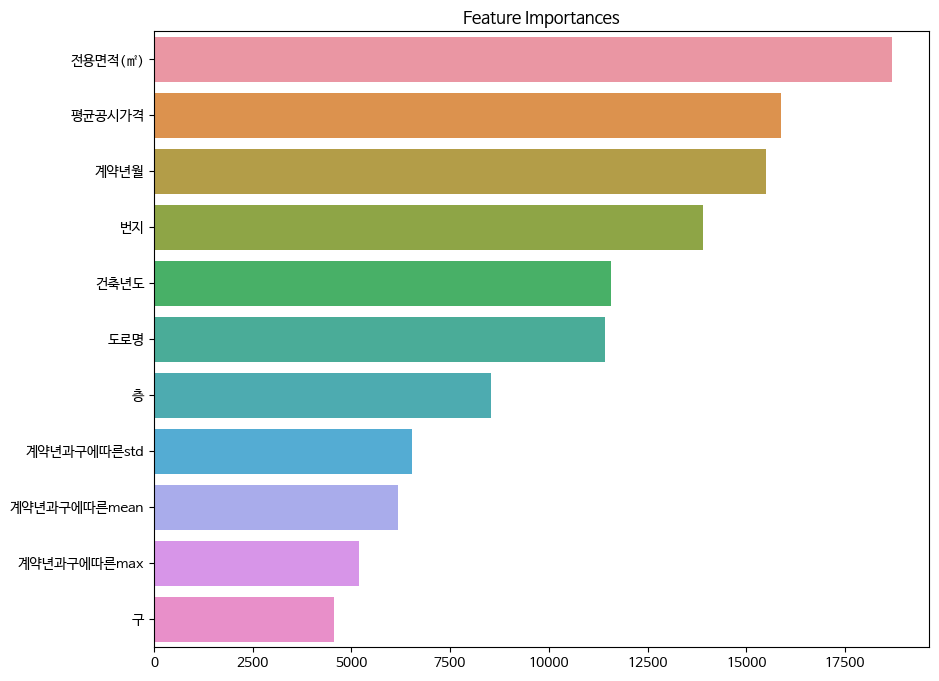

In [ ]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(gbm.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [30]:
preds_df.describe()

,target
count,9.272000e+03
mean,1.079884e+05
std,7.642338e+04
min,7.395000e+03
25%,6.287150e+04
50%,8.863750e+04
75%,1.279728e+05
max,1.079440e+06


NameError: name 'gmb' is not defined

In [ ]:
pred=gbm.predict(X_val)
pred

array([35572.45449135, 51060.85910474, 42510.58826838, ...,
       24213.54857515, 26420.37472143, 85130.6057825 ])

In [ ]:
val_index = X_val.index
w_col = ['시군구','아파트명','전용면적(㎡)','계약년월','건축년도','target']
train_val=dt_train.loc[val_index,w_col]

train_val['pred']= pred
train_val['err'] = train_val['target'] - train_val['pred']
train_val['err'] = train_val['err'].abs()

In [ ]:
train_val[train_val.err>=100000]

,시군구,아파트명,전용면적(㎡),계약년월,건축년도,target,pred,err
990274,서울특별시 서초구 반포동,반포주공1단지,106.250,201004,1973,37500,174783.112692,137283.112692
611770,서울특별시 성동구 성수동1가,갤러리아포레,241.930,201603,2011,465000,567958.221846,102958.221846
138844,서울특별시 강남구 도곡동,타워팰리스1,121.420,200908,2002,53000,161330.153040,108330.153040
717781,서울특별시 서초구 방배동,레베빌,244.920,201501,2000,373000,249880.108035,123119.891965
87297,서울특별시 용산구 한남동,한남더힐,240.305,201802,2011,575000,465700.115152,109299.884848
...,...,...,...,...,...,...,...,...
241238,서울특별시 강남구 청담동,PH129,273.960,202103,2020,1150000,787016.379777,362983.620223
851256,서울특별시 강남구 청담동,연세힐하우스1,187.730,201212,2003,232500,131771.399874,100728.600126
848234,서울특별시 강남구 논현동,논현라폴리움,263.930,201210,2012,453000,349187.309505,103812.690495
751425,서울특별시 용산구 한남동,한남더힐,244.783,201501,2011,750000,574983.959777,175016.040223


In [ ]:
train_val

,시군구,아파트명,전용면적(㎡),계약년월,건축년도,target,pred,err
859108,서울특별시 관악구 신림동,신림현대,105.360,201211,1993,33400,35572.454491,2172.454491
261109,서울특별시 노원구 중계동,중계그린1단지,39.920,202105,1990,52500,51060.859105,1439.140895
382608,서울특별시 은평구 신사동,신사씨티,82.710,202007,1993,43000,42510.588268,489.411732
2938,서울특별시 강남구 삼성동,롯데캐슬프레미어,84.465,201808,2007,182000,183225.982700,1225.982700
187091,서울특별시 송파구 장지동,송파파인타운3단지,84.940,200902,2008,53000,44633.514254,8366.485746
...,...,...,...,...,...,...,...,...
756411,서울특별시 종로구 창신동,창신쌍용2,115.530,201503,1993,42000,40443.017315,1556.982685
528485,서울특별시 양천구 신정동,목동신시가지14,74.190,201706,1987,71000,74615.996335,3615.996335
468126,서울특별시 구로구 개봉동,진로,59.820,201709,2000,20900,24213.548575,3313.548575
123810,서울특별시 성북구 정릉동,정릉푸른마을동아,59.940,201112,2003,26500,26420.374721,79.625279
